In [30]:
import uproot 
import awkward as ak
import numpy as np
import vector
import torch
import torch_hep
import torch_geometric
import itertools
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx
from sklearn.model_selection import train_test_split
import sklearn
import mplhep as hep
import boost_histogram as bh
import time
import os


from torch_geometric.loader import DataLoader


In [31]:
path = 'C:\\Users\\HP\\OneDrive\\Documents\\internships\\summer internship\\making cuts\\ttHH_tttt\\'
tree_tthh = uproot.open(path + 'ttHH_combined.root:AnalysisMiniTree')
tree_4top = uproot.open(path + '4top_aMCPy8EG_SSML.root:reco')


selection = [branch for branch in tree_tthh.keys() if 'Jet' in branch and 'NOSYS' in branch]

# # 'ttHH_nJets_NOSYS'
# # 'ttHH_nBJets_NOSYS'
# tree_tthh['ttHH_nBJets_NOSYS'].array()
# len(tree_tthh.keys())

In [32]:
[i for i in tree_4top.keys() if 'charge' in i]

['mu_charge', 'el_charge', 'lepton_charge']

In [33]:
def create_vector(type, tree, parameters, string):
    array = []
    for i in parameters:
        array.append(tree[f'{string[0]}_{type}_{i}_{string[1]}'].array())
    return vector.zip({param:array[j] for j, param in enumerate(parameters)})

In [34]:
lepton1 = create_vector('Lepton1', tree_tthh, ['pt','eta','phi','E'], ['ttHH', 'NOSYS'])
lepton2 = create_vector('Lepton2', tree_tthh, ['pt','eta','phi','E'], ['ttHH', 'NOSYS'])

bjet1 = create_vector('Jet_b1', tree_tthh, ['pt','eta','phi','E'], ['ttHH', 'NOSYS'])
bjet2 = create_vector('Jet_b2', tree_tthh, ['pt','eta','phi','E'], ['ttHH', 'NOSYS'])
bjet3 = create_vector('Jet_b3', tree_tthh, ['pt','eta','phi','E'], ['ttHH', 'NOSYS'])
bjet4 = create_vector('Jet_b4', tree_tthh, ['pt','eta','phi','E'], ['ttHH', 'NOSYS'])

cut_m = (lepton1.m >0) & (lepton2.m > 0) & (bjet1.m >0) & (bjet2.m >0) & (bjet3.m >0) & (bjet4.m >0)
cut_pt = (lepton1.pt >0) & (lepton2.pt > 0) & (bjet1.pt >0) & (bjet2.pt >0) & (bjet3.pt >0) & (bjet4.pt >0)
cut_eta = (lepton1.eta >-5) & (lepton2.eta > -5) & (bjet1.eta >-5) & (bjet2.eta >-5) & (bjet3.eta >-5) & (bjet4.eta >-5)
cut_phi = (lepton1.phi >-5) & (lepton2.phi > -5) & (bjet1.phi >-5) & (bjet2.phi >-5) & (bjet3.phi >-5) & (bjet4.phi >-5)
mask_tthh = cut_m & cut_pt & cut_eta & cut_phi

lepton1, lepton2, bjet1, bjet2, bjet3, bjet4 = lepton1[mask_tthh], lepton2[mask_tthh], bjet1[mask_tthh], bjet2[mask_tthh], bjet3[mask_tthh], bjet4[mask_tthh]

In [35]:
def create_entry1(entries, tree, string):
    dic = {}
    for entry in entries:
        dic[entry] = np.stack([tree[f'{string[0]}_{type}_{entry}_{string[1]}'].array()[mask_tthh] for type in ['Jet_b1','Jet_b2','Jet_b3','Jet_b4', 'Lepton1','Lepton2']], axis=1)
    return dic

def create_entry2(entries, tree, mask):
    dic = {}
    el_mu = np.concatenate([tree[f'el_pt_NOSYS'].array()[mask], tree['mu_pt_NOSYS'].array()[mask]], axis = 1)
    dic['pt'] = np.concatenate([tree[f'truth_jet_pt'].array()[mask][:,0:4], el_mu], axis = 1)
    for entry in entries[1:]:
        el_mu = np.concatenate([tree[f'el_{entry}'].array()[mask], tree[f'mu_{entry}'].array()[mask]], axis = 1)
        dic[entry] = np.concatenate([tree[f'truth_jet_{entry}'].array()[mask][:,0:4], el_mu], axis=1)
    return dic
    # probably need to order electrons and muons based on pt


In [36]:

dic_tthh = create_entry1(['pt', 'eta', 'phi', 'E'], tree_tthh, ['ttHH', 'NOSYS'])
# , 'pdgid', 'charge', 'btagged
length_tthh = len(dic_tthh['pt'])
a = (np.abs(tree_tthh['ttHH_Lepton1_pdgid_NOSYS'].array()[mask_tthh]) == 11)*1+(np.abs(tree_tthh['ttHH_Lepton1_pdgid_NOSYS'].array()[mask_tthh]) == 13)*2
b = (np.abs(tree_tthh['ttHH_Lepton1_pdgid_NOSYS'].array()[mask_tthh]) == 11)*1+(np.abs(tree_tthh['ttHH_Lepton1_pdgid_NOSYS'].array()[mask_tthh]) == 13)*2
dic_tthh['type'] = np.transpose(np.vstack((np.zeros((length_tthh,4)).T, a, b)))
charge1 = tree_tthh['ttHH_Lepton1_charge_NOSYS'].array()[mask_tthh]
charge2 = tree_tthh['ttHH_Lepton2_charge_NOSYS'].array()[mask_tthh]
dic_tthh['charge'] = np.transpose(np.vstack((np.zeros((length_tthh,4)).T, charge1, charge2)))
dic_tthh['b'] = np.concatenate([np.ones((length_tthh,4)), np.zeros((length_tthh, 2))], axis = 1)



In [37]:
mask_tttt = (ak.num(tree_4top['truth_jet_pt'].array(), axis = 1) >= 4) & (ak.num(tree_4top['el_pt_NOSYS'].array(), axis = 1) + ak.num(tree_4top['mu_pt_NOSYS'].array(), axis = 1) == 2)
dic_tttt = create_entry2(['pt', 'eta', 'phi', 'e'], tree_4top, mask_tttt)
length_tttt = len(dic_tttt['pt'])
num_el = ak.num(tree_4top['el_pt_NOSYS'].array()[mask_tttt], axis=1)
dic_tttt['type'] = np.hstack((np.zeros((length_tttt,4)), np.stack([np.ones((length_tttt)) * (num_el ==0)+1, np.ones((length_tttt)) * (num_el <2)+1], axis=1)))
dic_tttt['charge'] = np.concatenate([np.zeros((length_tttt,4)), tree_4top['el_charge'].array()[mask_tttt], tree_4top['mu_charge'].array()[mask_tttt]], axis=1)
dic_tttt['b'] = np.concatenate([np.ones((length_tttt,4)), np.zeros((length_tttt, 2))], axis = 1)



In [38]:

dataset = []

for i in range(length_tthh):
    G = torch_hep.graph.GraphBuilder()
    G.add_asNode(key='x', pt = dic_tthh['pt'][i], eta = dic_tthh['eta'][i], phi = dic_tthh['phi'][i], E = dic_tthh['E'][i], type = dic_tthh['type'][i], charge = dic_tthh['charge'][i], b = dic_tthh['b'][i],dtype=torch.float32)
    G.add_asEdge(key='edge_attrs', index=list(itertools.permutations(range(len(dic_tthh['pt'][i])),2)), dtype=torch.int64)
    G.add_asGlobal(key='y', IsSIG=1, dtype=torch.float32)
    # G.add_asGlobal(key='w', weight=1, dtype=torch.float32)

    dataset.append(G.to_Data())

for i in range(length_tttt):
    G = torch_hep.graph.GraphBuilder()
    G.add_asNode(key='x', pt = dic_tttt['pt'][i] ,eta = dic_tttt['eta'][i], phi = dic_tttt['phi'][i] , E = dic_tttt['e'][i], type = dic_tttt['type'][i], charge = dic_tttt['charge'][i], b = dic_tttt['b'][i],dtype=torch.float32)
    G.add_asEdge(key='edge_attrs', index=list(itertools.permutations(range(len(dic_tttt['pt'][i])),2)), dtype=torch.int64)
    G.add_asGlobal(key='y', IsSIG=0, dtype=torch.float32)
    # G.add_asGlobal(key='w', weight=0.12, dtype=torch.float32)

    dataset.append(G.to_Data())



In [39]:
length_tthh/length_tttt

0.12338344572007107

In [40]:
data = dataset[0]  # Get the first graph object.
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: 2')

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: [Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_features=[7]), Data(x=[6, 7], edge_index=[2, 30], y=1.0, x_f

In [41]:
seed = 1415
torch.manual_seed(seed)
np.random.seed(seed)
np.random.shuffle(dataset)
cutoff = int(len(dataset)*0.8)
#cutoff = 1000

train_dataset = dataset[:cutoff]
test_dataset = dataset[cutoff:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'percentage of graphs that are signal: {100* length_tthh/(length_tthh + length_tttt):.2f}%')


Number of training graphs: 47046
Number of test graphs: 11762
percentage of graphs that are signal: 10.98%


In [42]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)
scaler_loader = [i for i in DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)][0]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(scaler_loader.x)
total_loader = [i for i in DataLoader(dataset, batch_size=len(dataset), shuffle=True)][0]


In [43]:
from torch import nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import scatter

from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_convs):
        super(GCN, self).__init__()
        self.convs = nn.ModuleList()  # Use ModuleList to store layers
        self.convs.append(GCNConv(7, hidden_channels))
        for _ in range(num_convs - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.lin = nn.Linear(hidden_channels, 1)  # Linear layer for final output
        # GraphConv
        # GCNConv


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.01, training=self.training)
        x = self.lin(x)

        return torch.nn.functional.sigmoid(x)
    def __str__(self):
        return 'GCN'
    
class Graph(torch.nn.Module):
    def __init__(self, hidden_channels, num_convs):
        super(Graph, self).__init__()
        self.convs = nn.ModuleList()  # Use ModuleList to store layers
        self.convs.append(GraphConv(7, hidden_channels))
        for _ in range(num_convs - 1):
            self.convs.append(GraphConv(hidden_channels, hidden_channels))
        self.lin = nn.Linear(hidden_channels, 1)  # Linear layer for final output
        # GraphConv
        # GCNConv


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.01, training=self.training)
        x = self.lin(x)

        return torch.nn.functional.sigmoid(x)
    def __str__(self):
        return 'GRAPH'
    #GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_convs):
        super(GAT, self).__init__()
        self.convs = nn.ModuleList()  # Use ModuleList to store layers
        self.convs.append(GATConv(7, hidden_channels))
        for _ in range(num_convs - 1):
            self.convs.append(GATConv(hidden_channels, hidden_channels))
        self.lin = nn.Linear(hidden_channels, 1)  # Linear layer for final output
        # GraphConv
        # GCNConv


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.01, training=self.training)
        x = self.lin(x)

        return torch.nn.functional.sigmoid(x)
    def __str__(self):
        return 'GAT'
    
class SAGE(torch.nn.Module):
    def __init__(self, hidden_channels, num_convs):
        super(SAGE, self).__init__()
        self.convs = nn.ModuleList()  # Use ModuleList to store layers
        self.convs.append(SAGEConv(7, hidden_channels))
        for _ in range(num_convs - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.lin = nn.Linear(hidden_channels, 1)  # Linear layer for final output
        # GraphConv
        # GCNConv



    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.01, training=self.training)
        x = self.lin(x)

        return torch.nn.functional.sigmoid(x)
    def __str__(self):
        return 'SAGE'

In [49]:
class_type = GCN
layers = 3
hidden_dims = 64


model = class_type(hidden_channels=hidden_dims, num_convs =layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
criterion = torch.nn.BCELoss(reduction = 'mean')


test_results =  np.empty((0,2))
train_results =  np.empty((0,2))


In [45]:
def plot_signal_background(test_results, train_results, decisions_nn, test_y, class_type, layers, hidden_dims, save=False):
    fpr_nn, tpr_nn, thresholds_nn = sklearn.metrics.roc_curve(test_y, decisions_nn)
    # may need decisions to be 2 dimensional
    class_str = class_type.__str__(class_type)

    plt.plot(fpr_nn, tpr_nn, linestyle="dashed", label="Neural Network")  # plot neural network ROC
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
    plt.xlabel("False Positive Rate")  # x-axis label
    plt.ylabel("True Positive Rate")  # y-axis label
    plt.ylim(0,1)
    plt.title(f'{class_str}, layers {layers}, dims {hidden_dims} ROC plot')
    plt.grid()  # add a grid to the plot
    plt.legend()  # add a legend
    if save:
        plt.savefig(f'plots/{class_str}, layers {layers}, dims {hidden_dims} ROC plot.png')
    plt.show()


    plt.plot(np.arange(len(train_results)), train_results[:,1],linestyle='-', marker='o',  label = 'train loss')
    plt.plot(np.arange(len(test_results)), test_results[:,1], linestyle='-', marker='o', label = 'test loss')
    plt.xlabel("Epochs")  # x-axis label
    plt.ylabel("Loss")  # y-axis label
    plt.title(f'Loss at each Epoch')
    plt.legend()
    if save:
        plt.savefig(f'plots/{class_str}, layers {layers}, dims {hidden_dims} loss at each epoch.png')
    plt.show()

    plt.plot(np.arange(len(train_results)), train_results[:,0],linestyle='-', marker='o',  label = 'train accuracy')
    plt.plot(np.arange(len(train_results)), train_results[:,0], linestyle='-', marker='o', label = 'test accuracy')
    plt.xlabel("Epochs")  # x-axis label
    plt.ylabel("Percentage Accuracy")  # y-axis label
    plt.title(f'Accuracy')
    plt.legend()
    if save:
        plt.savefig(f'plots/{class_str}, layers {layers}, dims {hidden_dims} accuracy at each epoch.png')
    plt.show()


    hep.style.use(hep.style.ATLAS)

    hist1 = bh.Histogram(bh.axis.Regular(5, 0, 1)) # Initialises empty histogram with 50 bins spanning [0,500]
    hist2 = bh.Histogram(bh.axis.Regular(5, 0, 1))
    hist1.fill(decisions_nn[test_y==1])    # Fills the histogram with some data
    hist2.fill(decisions_nn[test_y ==0])

    hep.histplot([hist1/hist1.size, hist2/hist2.size], label = ['signal', 'background'])
    plt.xlabel('signal confidence')
    plt.ylabel('Normalized Frequency')
    plt.title(f'signal background plot')
    plt.legend()
    #plt.xlim(0,1)
    if save:
        plt.savefig(f'plots/{class_str}, layers {layers}, dims {hidden_dims} signal background.png')
    plt.show()



In [46]:
def plot(out, y, zoomed = False):
    hep.style.use(hep.style.ATLAS)
    if zoomed:
        hist1 = bh.Histogram(bh.axis.Regular(50, 0.98, 1)) # Initialises empty histogram with 50 bins spanning [0,500]
        hist2 = bh.Histogram(bh.axis.Regular(50, 0.98, 1))
    else:
        hist1 = bh.Histogram(bh.axis.Regular(5, 0, 1)) # Initialises empty histogram with 50 bins spanning [0,500]
        hist2 = bh.Histogram(bh.axis.Regular(5, 0, 1))
    hist1.fill(out[y==1])    # Fills the histogram with some data
    hist2.fill(out[y ==0])


    hep.histplot([hist1/hist1.size, hist2/hist2.size], label = ['signal', 'background'])
    plt.xlabel('signal confidence')
    plt.ylabel('Normalized Frequency')
    plt.title(f'signal background plot')
    plt.legend()
    #plt.xlim(0,1)
    #plt.savefig(f'using_adam_images\{dim} signal background zoomed.png')
    plt.show()

In [47]:
from torcheval.metrics import BinaryAccuracy
def train(scaler):
    train_loss = 0
    model.train()
    #out_numpy = np.array([])
    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.    
        x_transformed = torch.tensor(scaler.transform(data.x),dtype=torch.float32)
        out = model(x_transformed, data.edge_index, data.batch)  # Perform a single forward pass.
        # loss = torch.sum(criterion(out, data.y.reshape(-1,1))*data.w.reshape(-1,1)) / data.w.sum()# Compute the loss.
        loss = criterion(out, data.y.reshape(-1,1))
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        

def test(loader, scaler, output = ''):
    model.eval()
    metric = BinaryAccuracy()

    preds_array = np.array([])
    total_loss = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        x_transformed = torch.tensor(scaler.transform(data.x),dtype=torch.float32)
        out = model(x_transformed, data.edge_index, data.batch)
        preds = (out.cpu().detach().numpy()>0.5)[:,0]*1
        preds_array = np.hstack((preds_array, preds))
        metric.update(out.flatten(), data.y)
        loss = criterion(out, data.y.reshape(-1,1))
        total_loss += loss.item() * data.size(0)
    total_loss /= len(loader.dataset)
    signal_rate = np.sum(preds_array>0.5)/len(preds_array)
    accuracy = metric.compute()
    if output:
        print(f'{output} accuracy: {100*accuracy:.3f}% , loss: {total_loss:.4f}, signal rate: {100*signal_rate:.2f}% ')

    return accuracy.item(), total_loss, signal_rate



for each epoch:
train accuracy, train loss, train signal rate
test accuracy, test loss, test signal rate


In [50]:

for epoch in range(10):
    t1 = time.perf_counter()
    train(scaler)
    print(f'Epoch: {epoch:03d}')
    train_results = np.vstack((train_results, test(train_loader,scaler, 'train')[:-1]))
    test_results = np.vstack((test_results, test(test_loader,scaler, 'test')[:-1]))
    print()

Epoch: 000
train accuracy: 89.026% , loss: 2.3728, signal rate: 0.00% 
test accuracy: 88.981% , loss: 2.3705, signal rate: 0.00% 

Epoch: 001
train accuracy: 89.026% , loss: 1.8942, signal rate: 0.00% 
test accuracy: 88.981% , loss: 1.8915, signal rate: 0.00% 

Epoch: 002
train accuracy: 89.026% , loss: 1.7288, signal rate: 0.00% 
test accuracy: 88.981% , loss: 1.7257, signal rate: 0.00% 

Epoch: 003
train accuracy: 89.026% , loss: 1.4672, signal rate: 0.00% 
test accuracy: 88.981% , loss: 1.4628, signal rate: 0.00% 

Epoch: 004
train accuracy: 89.026% , loss: 1.0785, signal rate: 0.00% 
test accuracy: 88.981% , loss: 1.0711, signal rate: 0.00% 

Epoch: 005
train accuracy: 98.142% , loss: 0.6133, signal rate: 9.12% 
test accuracy: 98.232% , loss: 0.5998, signal rate: 9.25% 

Epoch: 006
train accuracy: 99.290% , loss: 0.3523, signal rate: 10.26% 
test accuracy: 99.362% , loss: 0.3316, signal rate: 10.38% 

Epoch: 007
train accuracy: 99.358% , loss: 0.2706, signal rate: 10.33% 
test accu

In [51]:
test_out = np.array([]) # first element is prediction, last element is what it should be
test_y = np.array([])
for data in test_loader:
    x_transformed = torch.tensor(scaler.transform(data.x),dtype=torch.float32)
    out = model(x_transformed, data.edge_index, data.batch).cpu().detach().numpy()[:,0]
    test_out = np.hstack((test_out, out))
    test_y = np.hstack((test_y, np.array(data.y)))
y_pred_test = (test_out>0.5)*1

print(sklearn.metrics.classification_report(test_y, y_pred_test, target_names=["background", "signal"]))




              precision    recall  f1-score   support

  background       0.99      1.00      1.00     10466
      signal       1.00      0.95      0.97      1296

    accuracy                           0.99     11762
   macro avg       1.00      0.97      0.99     11762
weighted avg       0.99      0.99      0.99     11762



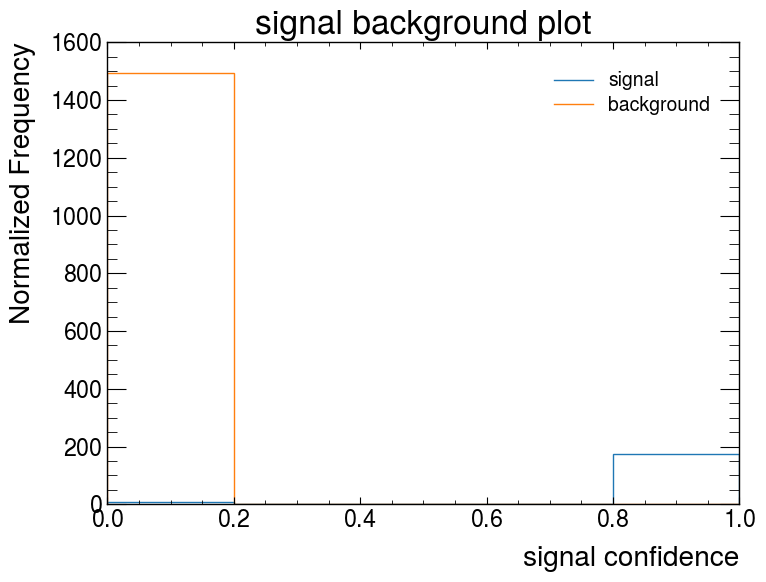

In [52]:
plot(test_out, test_y)

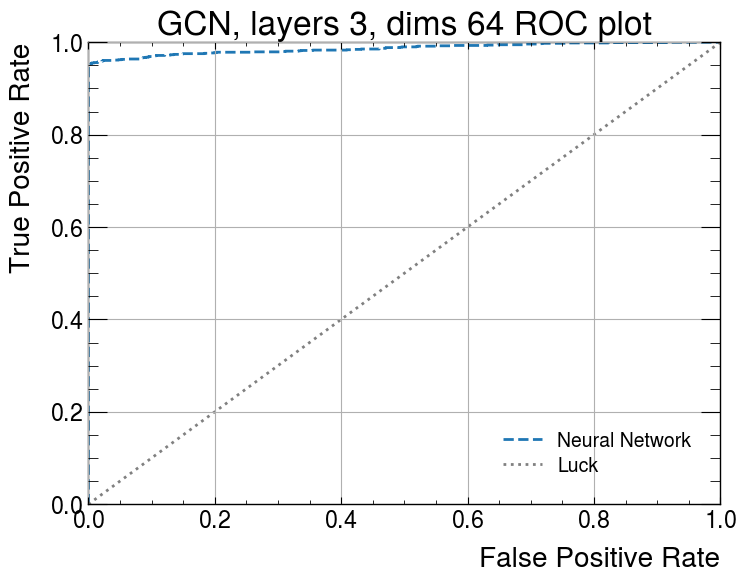

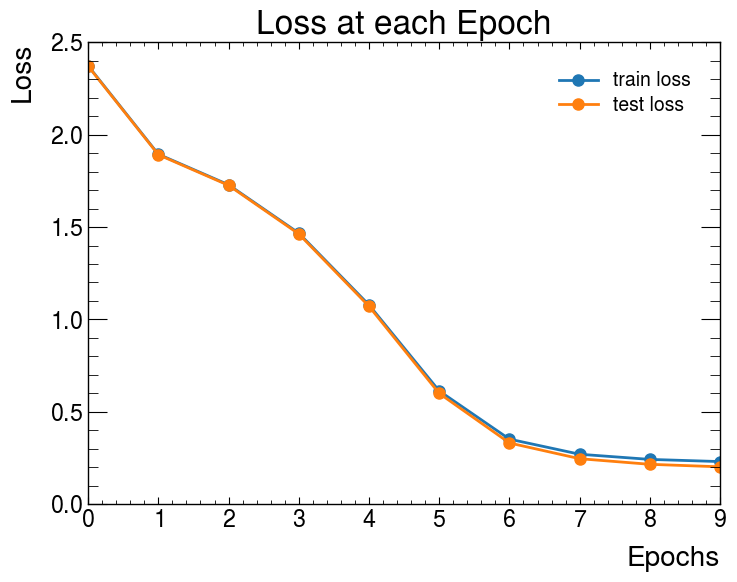

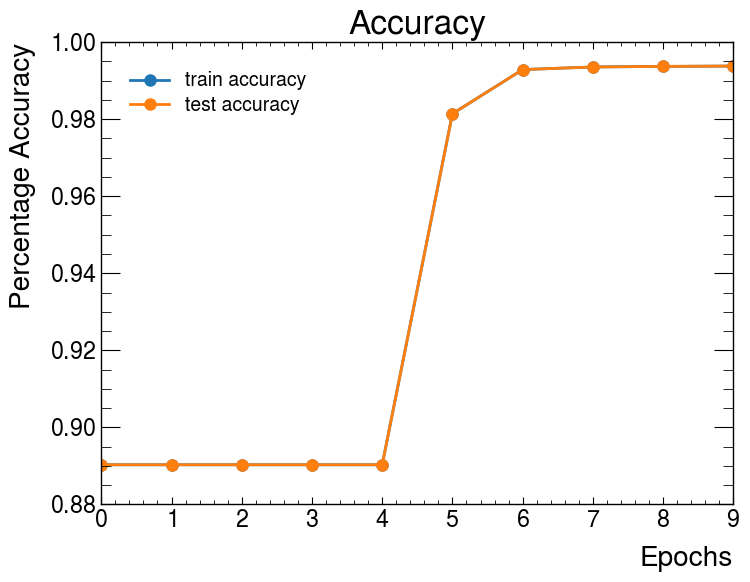

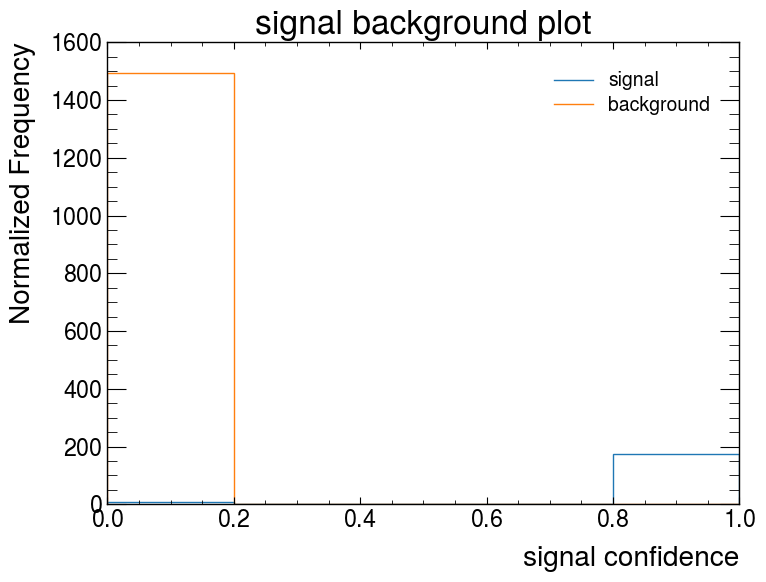

In [53]:
plot_signal_background(test_results, train_results, test_out, test_y, class_type, layers, hidden_dims)